In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from  tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
import numpy as np

In [3]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00:00:01


**Preprocess the images**

In [2]:
#Loading images 
data = []
labels = []
data = "/kaggle/input/face-mask-dataset/data"
images = []
labels=[]
category = ["with_mask", "without_mask"]

for c in category:
    path = os.path.join(data, c)
    for i in os.listdir(path):
        p= os.path.join(path, i)
        image = load_img(p, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        images.append(image)
        labels.append(c)

images = np.array(images, dtype="float32")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
d = {'with_mask':1, 'without_mask':0}
a = ['with_mask', 'without_mask']

def func(x):
    return d[x]

l= list(map(func, labels))

**Train test split**

In [5]:
#Train_test_split 
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

**Image generator**

In [6]:
# ImageDataGenerator rotation
train_datagen = ImageDataGenerator(
                            rescale=1.0/255, 
                            zca_whitening=True,
                             rotation_range=30,
                            fill_mode='nearest',
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                             brightness_range=[0.4,1.5],
                             shear_range=0.0,
                            zoom_range=0.5,
                            )

test_datagen = ImageDataGenerator(rescale=1.0/255 )

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1047: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


**Model implementation**

In [7]:
base_model = VGG16(
    input_shape=(224, 224, 3),  # Shape of our images
    include_top=False,  # Leave out the last fully connected layer
    weights='imagenet'
)


for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [9]:
vgg = model.fit(train_datagen.flow(train_images, train_labels, batch_size=20),validation_data = test_datagen.flow(test_images, test_labels), epochs = 20, batch_size=128)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


303/303 ━━━━━━━━━━━━━━━━━━━━ 94s 277ms/step - acc: 0.7256 - loss: 0.5481 - val_acc: 0.9550 - val_loss: 0.1227


**Predict the test dataset**

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


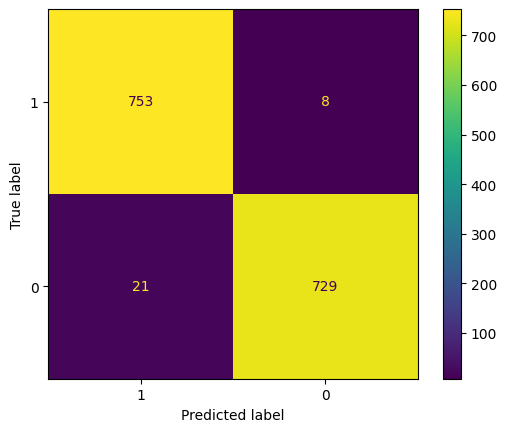

In [24]:
predictions = model.predict(test_images)

cm = confusion_matrix(test_labels[:,0], np.round(predictions[:,0]), labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot()

**Save models**

In [15]:
model.save("mask_detector.h5")